# 심층 합성곱 생성적 적대 신경망

- Deep Convolutional Generative Adversarial Network (DC GAN)

## 생성적 적대 신경망 (GAN) 이란

- [생성적 적대 신경망](https://arxiv.org/abs/1406.2661) (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나 입니다.
- 두개의 모델이 적대적인 과정을 통해 동시에 훈련 됩니다. (Generator + Discriminator)
- *생성자* ("예술가")는 진짜처럼 보이는 이미지를 생성하도록 배우는 와중에, *감별자* ("예술비평가")는 가짜의 이미지로부터 진짜를 구별하게 되는 것을 배우게 됩니다.

![생성자와 감별자를 그린 도표](https://tensorflow.org/tutorials/generative/images/gan1.png)

- 훈련과정 동안 *생성자*는 점차 실제같은 이미지를 더 잘 생성하게 됩니다.
- *감별자*는 점차 진짜와 가짜를 더 잘 구별하게 됩니다.
- 이 과정은 *감별자*가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달 합니다.

![생성자와 감별자를 그린 두번째 도표](https://tensorflow.org/tutorials/generative/images/gan2.png)

- 이 과정을 MNIST 데이터를 이용하여 구현해 봅니다.
- 아래의 애니메이션은 50 에포크(epoch)동안 훈련한 *생성자*가 생성해낸 연속된 이미지들을 보여줍니다.
- 이미지들은 랜덤한 잡음으로 부터 시작되었고, 점차 시간이 지남에 따라 손으로 쓴 숫자들을 닮아가게 됩니다.

![출력 예시](https://tensorflow.org/images/gan/dcgan.gif)

## 필요 라이브러리 로드

In [8]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import os
import PIL
import time
from IPython import display

In [ ]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

## 데이터셋 로딩 및 준비

- 생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용합니다.
- 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다.

In [10]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [11]:
train_images.shape

(60000, 28, 28)

- MNIST 손글씨는 (n_samples, 28, 28)의 shape을 가지는 0과 1 사이의 픽셀값을 갖는 이미지 데이터입니다.
- 이를 (n_samples, 28, 28, 1)의 shape을 가지는 0과 1 사이의 픽셀값을 갖는 이미지 데이터로 변환하고, 각 픽셀값을 -1에서 1 사이의 값으로 normalize해 줍니다.

In [12]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [13]:
train_images = (train_images - 127.5) / 127.5

In [14]:
train_images.shape

(60000, 28, 28, 1)

In [15]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

- `from_tensor_slices()` 함수는 train_images 배열을 받아서 데이터셋을 생성합니다.
- 이 데이터셋은 `shuffle()` 함수를 사용하여 버퍼 사이즈만큼의 샘플들을 섞고, `batch()` 함수를 사용하여 BATCH_SIZE만큼의 샘플들로 이루어진 배치(batch)로 묶어줍니다.
- 이 때, `drop_remainder=True` 로 설정하면 데이터셋의 마지막 배치가 BATCH_SIZE보다 작은 경우 해당 배치를 버리게 됩니다.
- 마지막으로 `prefetch()` 함수를 사용하여 모델 학습 중 데이터를 CPU와 GPU 간에 비동기적으로 전달하며, 학습효율을 향상시킵니다.

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE)\
                .batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [17]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None)>

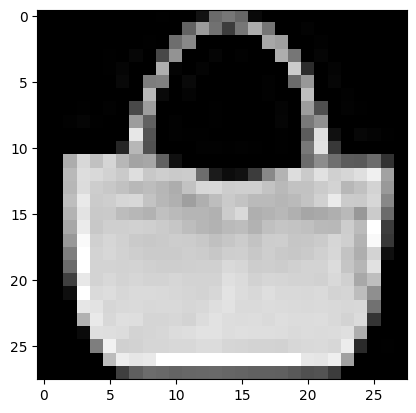

In [18]:
plt.imshow(train_images[100].reshape(28,28), cmap='gray')
plt.show()

## 모델 만들기

### 생성자 (Generator)

- 생성자는 시드값 (seed; 랜덤한 잡음)으로부터 CNN 의 역순으로 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (inverse Convolution 을 통한 upsampling) 층을 이용합니다.
- `stride=(2, 2)` 일 경우 dimension 이 2 배로 upsampling 됩니다.
- 처음 `Dense`층은 시드값을 인풋으로 받습니다.
- 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 Conv2DTranspose 를 이용한 업샘플링을 여러번 합니다.  
- tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목하세요.

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" width="700">

- "same" padding and stride = 1, 출력은 같은 크기입니다  
- "same" padding and stride = 2, 출력은 두배 크기입니다.

In [19]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7*7*256, use_bias=False, input_shape=(100,)), # seed 를 입력으로 받음, 출력 12544
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7,7,256)),
    tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'),
])

In [20]:
assert generator.output_shape == (None, 28, 28, 1)

In [21]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

- 생성된 이미지를 보기 위해 우선 랜덤한 noise 벡터를 만들고 (아직 훈련이 되지않은) 생성자을 통해 이미지를 생성합니다.
- `training=False` 인 경우 모델은 추론 모드이며, Dropout 및 BatchNormalization과 같은 레이어가 적용되지 않습니다.
- `training=True` 인 경우 모델은 학습 모드이며, Dropout 및 BatchNormalization과 같은 레이어가 적용됩니다.
- 이는 학습 단계에서 가중치 업데이트를 위한 필요한 노이즈와 무작위성을 추가하기 위한 것입니다.

In [22]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

In [23]:
generated_image.shape

TensorShape([1, 28, 28, 1])

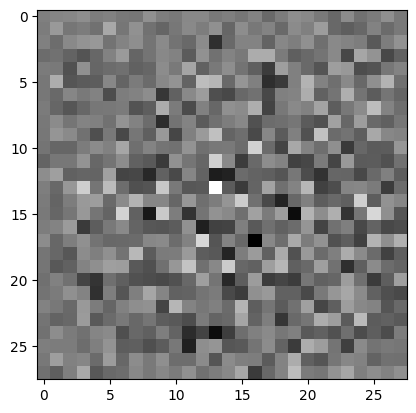

In [24]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### 감별자 (Discriminator)

- 감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기 입니다.  
- MNIST dataset 은 input_shape (28, 28, 1)  입니다.
- sigmoid output 은 probability scalar 값을 출력합니다.
- CNN 과의 차이 : pooling layer가 없고, stride 를 통하여 downsampling 을 합니다.

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" width="700">

In [25]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=(28,28,1)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

In [26]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

- (아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별해 봅니다.  
- 모델은 진짜 이미지에는 positive, 가짜 이미지에는 negative 를 출력하도록 훈련될 것입니다.

In [27]:
decision = discriminator(generated_image)

In [28]:
print(decision)

tf.Tensor([[0.00044247]], shape=(1, 1), dtype=float32)


## Loss Function 과 Optimizer 정의

- 두 모델의 손실함수와 옵티마이저를 별도로 정의합니다.
- Discriminator는 output 이 sigmoid 이므로, binary crossentropy 를 loss function 으로 사용합니다.
- `from_logits=True` 는 모델의 출력값이 logits 형태로 나오는 경우 사용됩니다.

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수

- discriminator_loss 함수는 real_output과 fake_output 두 가지 인자를 받아, 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.
- `tf.ones_like(real_output)` 는 real_output과 같은 모양(shape)의 텐서를 생성하여 1로 채우고,
- `tf.zeros_like(fake_output)` 는 fake_output과 같은 모양의 텐서를 생성하여 0으로 채웁니다.
- 이 두 텐서는 각각 진짜 데이터와 가짜 데이터에 대한 레이블을 나타냅니다.
- real_loss는 real_output과 레이블이 1인 `tf.ones_like(real_output)` 간의 이진 교차 엔트로피 손실을 계산하고, fake_loss는 fake_output과 레이블이 0인 `tf.zeros_like(fake_output)` 간의 이진 교차 엔트로피 손실을 계산합니다.
- real image 는 label [11111..111], fake image 는 label [00000....000] 이 ground truth 가 됩니다.
- 마지막으로, total_loss는 real_loss와 fake_loss를 더한 값입니다.
- discriminator 는 real 은 real 로, fake 는 fake 로 바르게 판별해야 하므로 real_loss + fake_loss 가 minimize 되도록 training 합니다.

In [30]:
tf.ones_like([0,0,0,0,0]), tf.zeros_like([1, 2, 3, 4, 5])

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>)

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

### 생성자 손실함수

- 감별자를 얼마나 잘 속였는지에 대해 수치화 합니다.
- generator_loss 함수는 fake_output 인자를 받아, 가짜 데이터에 대한 discriminator의 출력값을 반환합니다.
- `tf.ones_like(fake_output)`는 fake_output과 같은 모양(shape)의 텐서를 생성하여 1로 채웁니다. 이 텐서는 가짜 데이터에 대한 레이블을 나타냅니다.
- 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것 입니다.
- 생성된 이미지에 대한 감별자의 결정(fake_output)을 1로 이루어진 행렬과 비교합니다.
- (감별자가 감별한 결과가 모두 1 이 되어야 생성자가 감별자를 완벽히 속인 것임)  

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 생성자 옵티마이저

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

### 감별자 옵티마이저

In [34]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

### 체크포인트 저장

- optimizer 와 model을 저장합니다.
- 이렇게 생성된 체크포인트를 사용하면, 모델 학습 과정 중간에 중단되었을 경우 체크포인트 파일을 불러와서 학습을 이어나갈 수 있습니다.

In [35]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

In [36]:
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## 훈련 루프 정의

- 훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작 합니다.
- 그 시드값을 사용하여 이미지를 생성 합니다.  
- 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류 합니다.
- 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트 합니다.

<img src="./images/adverseModel.png" width="500">

<img src="./images/GANTraining.png" width="500">

In [47]:
# EPOCHS = 50
EPOCHS = 20
noise_dim = 100
num_examples_to_generator = 16

In [48]:
seed = tf.random.normal([num_examples_to_generator, noise_dim])

In [49]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-1.2380846 ,  1.1847991 ,  0.7031872 , ...,  0.11381425,
         2.2812703 ,  0.37522408],
       [ 0.40100908,  0.02504477, -0.5121845 , ..., -1.763696  ,
        -1.4221586 ,  1.0379144 ],
       [-0.7881324 , -0.40511248,  1.4667821 , ..., -0.03869968,
         0.5268335 ,  1.1536857 ],
       ...,
       [-1.0888984 , -0.51406777, -0.16381161, ..., -0.37517405,
         0.65836686,  0.87972075],
       [ 0.70177805,  0.68247426,  0.30200157, ...,  0.71075076,
        -0.5257679 , -0.77952784],
       [ 0.00532209, -2.0150876 ,  0.4357313 , ..., -0.11182655,
        -0.61706114,  0.8196255 ]], dtype=float32)>

- `@tf.function` 데코레이터는 함수를 컴파일

In [50]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**이미지 생성 및 저장**
-`training`이 False로 맞춰진 것을 주목. 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.

In [51]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'Image_at_Epoch_{epoch:04d}.png')
    plt.show()

In [52]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f'Epoch {epoch + 1} 에서 소요된 시간은 {time.time() - start}초 입니다.')

    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## 모델 훈련

- 위에 정의된 `train()` 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출  합니다.  
- 생성적 적대 신경망을 학습하는 것은 매우 까다롭다. 생성자와 감별자가 서로를 제압하지 않는 것이 중요 합니다. (비슷한 속도로 train)
- 훈련 초반부에는 생성된 이미지는 랜덤 노이즈처럼 보이나 훈련이 진행될수록, 생성된 숫자는 점차 진짜와 비슷해집니다.  
- 약 50 에포크가 지난 후, MNIST 와 닮은 이미지가 생성 됩니다.
- Colab에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요 됩니다.

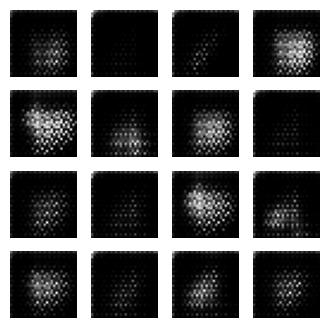

Epoch 1 에서 소요된 시간은 36.92037868499756초 입니다.


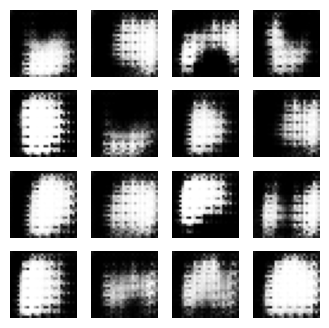

Epoch 2 에서 소요된 시간은 29.181331157684326초 입니다.


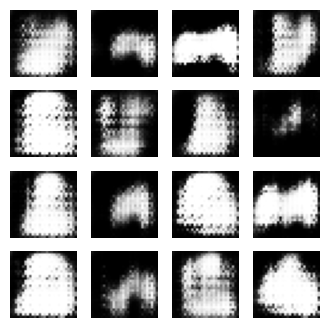

Epoch 3 에서 소요된 시간은 29.581684350967407초 입니다.


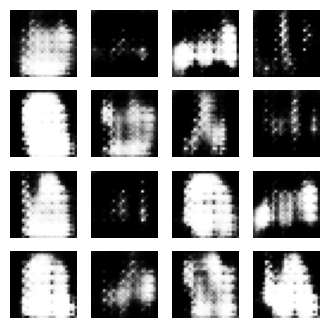

Epoch 4 에서 소요된 시간은 29.021840572357178초 입니다.


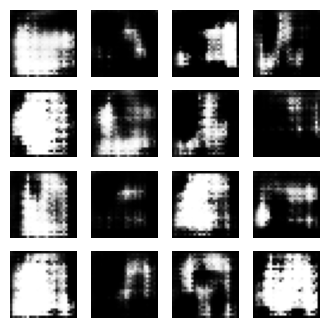

Epoch 5 에서 소요된 시간은 29.21100616455078초 입니다.


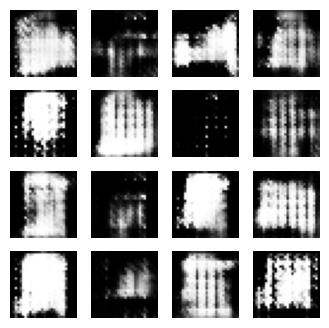

Epoch 6 에서 소요된 시간은 29.001444339752197초 입니다.


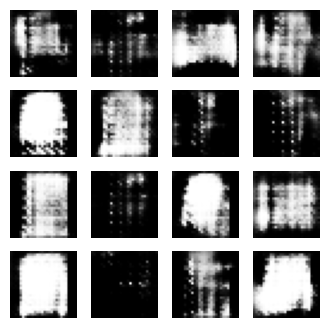

Epoch 7 에서 소요된 시간은 28.958232641220093초 입니다.


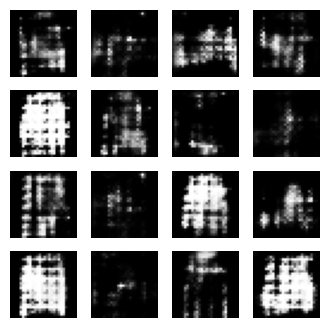

Epoch 8 에서 소요된 시간은 28.940226793289185초 입니다.


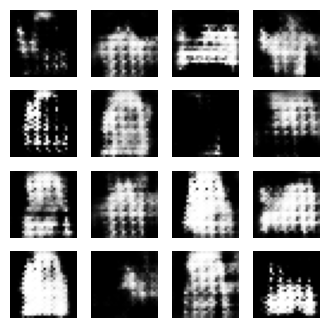

Epoch 9 에서 소요된 시간은 29.339354276657104초 입니다.


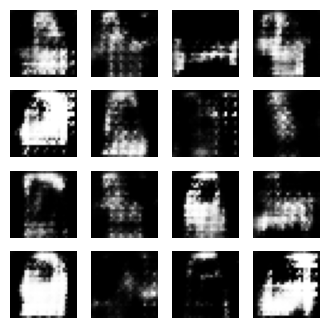

Epoch 10 에서 소요된 시간은 29.01882243156433초 입니다.


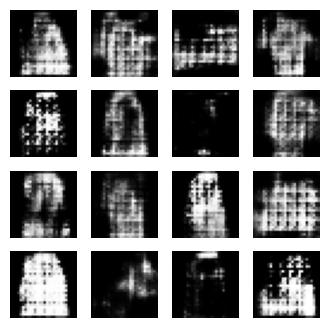

Epoch 11 에서 소요된 시간은 29.05966091156006초 입니다.


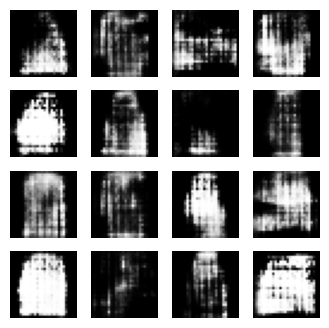

Epoch 12 에서 소요된 시간은 29.160860300064087초 입니다.


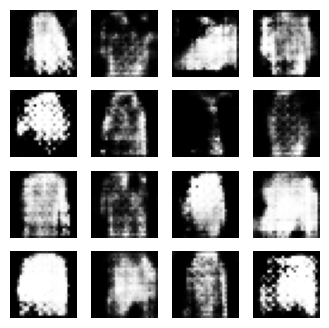

Epoch 13 에서 소요된 시간은 29.254879474639893초 입니다.


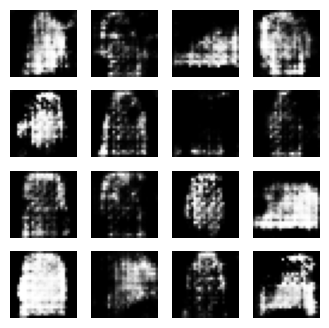

Epoch 14 에서 소요된 시간은 28.96451210975647초 입니다.


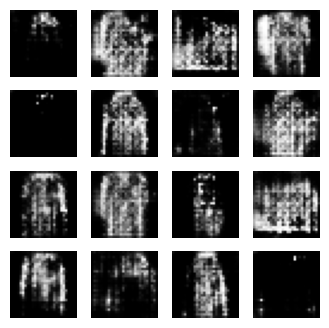

Epoch 15 에서 소요된 시간은 29.284993171691895초 입니다.


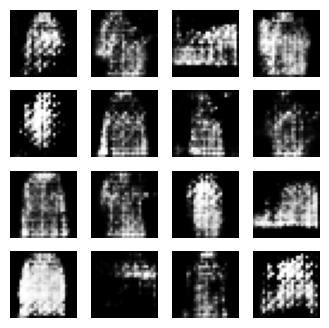

Epoch 16 에서 소요된 시간은 28.95814085006714초 입니다.


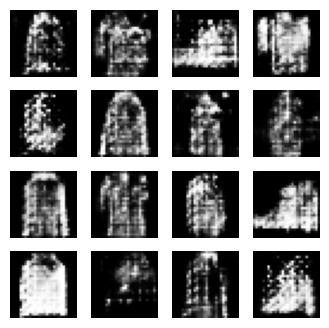

Epoch 17 에서 소요된 시간은 29.473718404769897초 입니다.


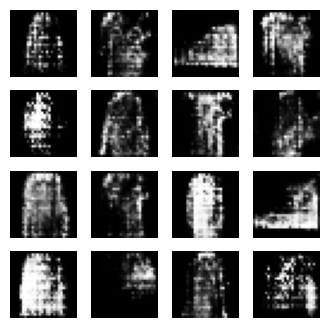

Epoch 18 에서 소요된 시간은 28.991710901260376초 입니다.


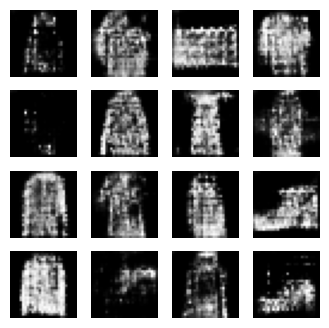

Epoch 19 에서 소요된 시간은 28.998043537139893초 입니다.


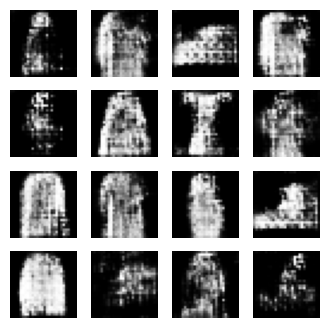

Epoch 20 에서 소요된 시간은 28.998902320861816초 입니다.


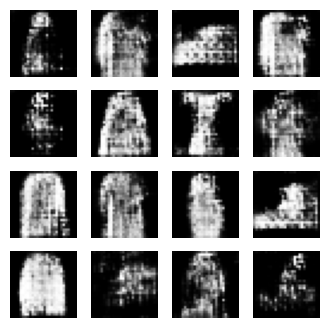

CPU times: user 1min 36s, sys: 21.8 s, total: 1min 57s
Wall time: 9min 51s


In [53]:
%%time
train(train_dataset, EPOCHS)

- 마지막 체크포인트를 복구합니다.

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir))

## 생성된 이미지 확인

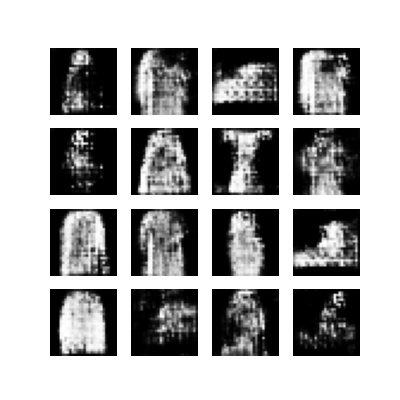

In [55]:
PIL.Image.open(f'Image_at_Epoch_{EPOCHS:04d}.png')